# Determine if a unit is providing marginal power

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gzip
import cPickle as pickle

/Users/Home/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Method
For every hour, find the change in **net** load from the previous hour. Net load is defined as total load minus wind generation.

### Change in net load
Use ERCOT data on hourly load and hourly wind generation to create `Net Load` and `Net Change` columns.

In [2]:
filename = 'ERCOT wind data.csv'
path = '../Clean Data'
fullpath = os.path.join(path, filename)
ercot = pd.read_csv(fullpath, index_col=0)

In [3]:
ercot.head()

,"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed","Wind Output, % of Load",1-hr MW change,1-hr % change
2007-01-01 00:00:00,30428.0,2790.0,1074.0,38.494624,3.529644,NaN,NaN
2007-01-01 01:00:00,30133.0,2790.0,922.6,33.068100,3.061760,-151.4,-14.096834
2007-01-01 02:00:00,29941.0,2790.0,849.2,30.437276,2.836245,-73.4,-7.955777
2007-01-01 03:00:00,29949.0,2790.0,1056.3,37.860215,3.526996,207.1,24.387659
2007-01-01 04:00:00,30248.0,2790.0,837.1,30.003584,2.767456,-219.2,-20.751680


In [4]:
ercot.loc[:,'Net Load'] = ercot.loc[:,'ERCOT Load, MW'] - ercot.loc[:,'Total Wind Output, MW']

In [5]:
ercot.head()

,"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed","Wind Output, % of Load",1-hr MW change,1-hr % change,Net Load
2007-01-01 00:00:00,30428.0,2790.0,1074.0,38.494624,3.529644,NaN,NaN,29354.0
2007-01-01 01:00:00,30133.0,2790.0,922.6,33.068100,3.061760,-151.4,-14.096834,29210.4
2007-01-01 02:00:00,29941.0,2790.0,849.2,30.437276,2.836245,-73.4,-7.955777,29091.8
2007-01-01 03:00:00,29949.0,2790.0,1056.3,37.860215,3.526996,207.1,24.387659,28892.7
2007-01-01 04:00:00,30248.0,2790.0,837.1,30.003584,2.767456,-219.2,-20.751680,29410.9


In [6]:
ercot.loc[1:,'Net Change'] = ercot.iloc[1:,-1].values - ercot.iloc[:-1,-1].values

In [7]:
ercot.head()

,"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed","Wind Output, % of Load",1-hr MW change,1-hr % change,Net Load,Net Change
2007-01-01 00:00:00,30428.0,2790.0,1074.0,38.494624,3.529644,NaN,NaN,29354.0,NaN
2007-01-01 01:00:00,30133.0,2790.0,922.6,33.068100,3.061760,-151.4,-14.096834,29210.4,-143.6
2007-01-01 02:00:00,29941.0,2790.0,849.2,30.437276,2.836245,-73.4,-7.955777,29091.8,-118.6
2007-01-01 03:00:00,29949.0,2790.0,1056.3,37.860215,3.526996,207.1,24.387659,28892.7,-199.1
2007-01-01 04:00:00,30248.0,2790.0,837.1,30.003584,2.767456,-219.2,-20.751680,29410.9,518.2


### EPA data
Calculate the change in generation for each plant in every hour. By summing the change across all plants in a group (cluster), we will have the change in generation for that group from the previous hour to the current hour. 

In [8]:
# load a zipped pickle file 
# from http://stackoverflow.com/questions/18474791/decreasing-the-size-of-cpickle-objects
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [9]:
filename = 'EPA hourly dictionary.pgz'
path = '../Clean Data'
fullpath = os.path.join(path, filename)

epaDict = load_zipped_pickle(fullpath)

In [29]:
epaDict.keys()

['2012 Jan-June',
 '2007 July-Dec',
 '2013 Jan-June',
 '2008 July-Dec',
 '2011 Jan-June',
 '2010 Jan-June',
 '2010 July-Dec',
 '2009 July-Dec',
 '2015 Jan-June',
 '2015 July-Dec',
 '2012 July-Dec',
 '2007 Jan-June',
 '2008 Jan-June',
 '2011 July-Dec',
 '2014 Jan-June',
 '2014 July-Dec',
 '2009 Jan-June',
 '2013 July-Dec']

In [10]:
def plant_gen_delta(df):
    """
    For every plant in the input df, calculate the change in gross load (MW)
    from the previous hour.
    
    input:
        df: dataframe of EPA clean air markets data
    return:
        df: concatanated list of dataframes
    """
    df_list = []
    for plant in df['PLANT_ID'].unique():
        temp = df.loc[df['PLANT_ID'] == plant,:]
        gen_change = temp.loc[:,'GROSS LOAD (MW)'].values - temp.loc[:,'GROSS LOAD (MW)'].shift(1).values
        temp.loc[:,'Gen Change'] = gen_change
        df_list.append(temp)
    return pd.concat(df_list)

In [11]:
allEPA = pd.concat(epaDict)

In [12]:
allEPA.fillna(0, inplace=True)
allEPA.head()

CO2 (SHORT TONS)  COUNTY       DATE            DATETIME  \
2007 Jan-June 0               0.0  Harris 2007-01-01 2007-01-01 00:00:00   
              1               0.0  Harris 2007-01-01 2007-01-01 01:00:00   
              2               0.0  Harris 2007-01-01 2007-01-01 02:00:00   
              3               0.0  Harris 2007-01-01 2007-01-01 03:00:00   
              4               0.0  Harris 2007-01-01 2007-01-01 04:00:00   

                 EPA REGION  FACILITY LATITUDE  FACILITY LONGITUDE  \
2007 Jan-June 0           6            29.7239            -95.2258   
              1           6            29.7239            -95.2258   
              2           6            29.7239            -95.2258   
              3           6            29.7239            -95.2258   
              4           6            29.7239            -95.2258   

                          FACILITY NAME  GROSS LOAD (MW)  HEAT INPUT (MMBTU)  \
2007 Jan-June 0  AES Western Power, LLC              0.0                 0.0   
              1  AES Western Power, LLC              0.0                 0.0   
              2  AES Western Power, LLC              0.0                 0.0   
              3  AES Western Power, LLC              0.0                 0.0   
              4  AES Western Power, LLC              0.0                 0.0   

                 HOUR NERC REGION  NOX (POUNDS)  PLANT_ID  SO2 (POUNDS) STATE  \
2007 Jan-June 0     0       ERCOT           0.0      3461           0.0    TX   
              1     1       ERCOT           0.0      3461           0.0    TX   
              2     2       ERCOT           0.0      3461           0.0    TX   
              3     3       ERCOT           0.0      3461           0.0    TX   
              4     4       ERCOT           0.0      3461           0.0    TX   

                 STEAM LOAD (1000LB/HR)  YEAR  
2007 Jan-June 0                     0.0  2007  
              1                     0.0  2007  
              2                     0.0  2007  
              3                     0.0  2007  
              4                     0.0  2007

In [13]:
allEPA = plant_gen_delta(allEPA)

/Users/Home/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Home/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [14]:
allEPA.reset_index(drop=True, inplace=True)

In [15]:
allEPA.tail()

,CO2 (SHORT TONS),COUNTY,DATE,DATETIME,EPA REGION,FACILITY LATITUDE,FACILITY LONGITUDE,FACILITY NAME,GROSS LOAD (MW),HEAT INPUT (MMBTU),HOUR,NERC REGION,NOX (POUNDS),PLANT_ID,SO2 (POUNDS),STATE,STEAM LOAD (1000LB/HR),YEAR,Gen Change
4511875,395.801,Brazoria,2015-12-31,2015-12-31 19:00:00,6,29.0728,-95.745,Sweeny Cogeneration Facility,422.0,6660.4,19,ERCOT,174.4,55015,3.358,TX,0.0,2015,-1.0
4511876,397.101,Brazoria,2015-12-31,2015-12-31 20:00:00,6,29.0728,-95.745,Sweeny Cogeneration Facility,423.0,6681.5,20,ERCOT,153.7,55015,3.378,TX,0.0,2015,1.0
4511877,395.601,Brazoria,2015-12-31,2015-12-31 21:00:00,6,29.0728,-95.745,Sweeny Cogeneration Facility,420.0,6655.3,21,ERCOT,162.9,55015,3.364,TX,0.0,2015,-3.0
4511878,401.501,Brazoria,2015-12-31,2015-12-31 22:00:00,6,29.0728,-95.745,Sweeny Cogeneration Facility,420.0,6756.3,22,ERCOT,175.4,55015,3.383,TX,0.0,2015,0.0
4511879,403.300,Brazoria,2015-12-31,2015-12-31 23:00:00,6,29.0728,-95.745,Sweeny Cogeneration Facility,422.0,6787.3,23,ERCOT,156.4,55015,3.402,TX,0.0,2015,2.0


### Export EPA with change in generation

In [ ]:
filename = 'EPA with hourly gen change.csv'
path = '../Clean Data'
fullpath = os.path.join(path, filename)
allEPA.to_csv(fullpath)

### Plot the change in generation for plant id 298

In [86]:
plant_298 = allEPA.loc[allEPA['PLANT_ID'] == 298,:]

In [90]:
plant_298.tail()

,CO2 (SHORT TONS),COUNTY,DATE,DATETIME,EPA REGION,FACILITY LATITUDE,FACILITY LONGITUDE,FACILITY NAME,GROSS LOAD (MW),HEAT INPUT (MMBTU),HOUR,NERC REGION,NOX (POUNDS),PLANT_ID,SO2 (POUNDS),STATE,STEAM LOAD (1000LB/HR),YEAR,Gen Change
1617163,1504.3,Limestone,2015-12-31,2015-12-31 19:00:00,6,31.4219,-96.2525,Limestone,1552.0,13816.9,19,ERCOT,2418.4,298,5165.4,TX,0.0,2015,-39.0
1617164,1080.6,Limestone,2015-12-31,2015-12-31 20:00:00,6,31.4219,-96.2525,Limestone,1103.0,9925.9,20,ERCOT,1746.0,298,3614.5,TX,0.0,2015,-449.0
1617165,904.5,Limestone,2015-12-31,2015-12-31 21:00:00,6,31.4219,-96.2525,Limestone,903.0,8308.0,21,ERCOT,1690.4,298,2987.5,TX,0.0,2015,-200.0
1617166,913.6,Limestone,2015-12-31,2015-12-31 22:00:00,6,31.4219,-96.2525,Limestone,902.0,8391.6,22,ERCOT,1644.1,298,3046.2,TX,0.0,2015,-1.0
1617167,916.4,Limestone,2015-12-31,2015-12-31 23:00:00,6,31.4219,-96.2525,Limestone,901.0,8417.2,23,ERCOT,1575.6,298,3145.4,TX,0.0,2015,-1.0


In [91]:
plant_298.index = plant_298['DATETIME']

In [88]:
len(plant_298)
len(ercot)

78888

78889

In [89]:
ercot.tail()

,"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed","Wind Output, % of Load",1-hr MW change,1-hr % change,Net Load,Net Change
2015-12-31 19:00:00,39908.77734,16170.0,3824.932373,23.654498,9.584188,483.971191,14.485987,36083.844967,-1172.357911
2015-12-31 20:00:00,38736.85938,16170.0,4625.632813,28.606264,11.941166,800.700440,20.933715,34111.226567,-1972.618400
2015-12-31 21:00:00,37587.70313,16170.0,4957.714844,30.659956,13.189725,332.082031,7.179170,32629.988286,-1481.238281
2015-12-31 22:00:00,36356.26172,16170.0,4699.097656,29.060592,12.925140,-258.617188,-5.216460,31657.164064,-972.824222
2015-12-31 23:00:00,35150.33984,16170.0,4313.125000,26.673624,12.270507,-385.972656,-8.213761,30837.214840,-819.949224


In [93]:
test = pd.merge(ercot, plant_298, left_index=True, right_index=True)

In [94]:
test.head()

,"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed","Wind Output, % of Load",1-hr MW change,1-hr % change,Net Load,Net Change,CO2 (SHORT TONS),...,HEAT INPUT (MMBTU),HOUR,NERC REGION,NOX (POUNDS),PLANT_ID,SO2 (POUNDS),STATE,STEAM LOAD (1000LB/HR),YEAR,Gen Change
2007-01-01 00:00:00,30428.0,2790.0,1074.0,38.494624,3.529644,NaN,NaN,29354.0,NaN,1659.7,...,15245.2,0,ERCOT,2980.017,298,1902.5,TX,0.0,2007,NaN
2007-01-01 01:00:00,30133.0,2790.0,922.6,33.068100,3.061760,-151.4,-14.096834,29210.4,-143.6,1671.2,...,15350.9,1,ERCOT,2938.545,298,1924.9,TX,0.0,2007,36.0
2007-01-01 02:00:00,29941.0,2790.0,849.2,30.437276,2.836245,-73.4,-7.955777,29091.8,-118.6,1695.6,...,15574.5,2,ERCOT,2997.699,298,2236.8,TX,0.0,2007,16.0
2007-01-01 03:00:00,29949.0,2790.0,1056.3,37.860215,3.526996,207.1,24.387659,28892.7,-199.1,1695.9,...,15577.3,3,ERCOT,3014.622,298,2840.0,TX,0.0,2007,10.0
2007-01-01 04:00:00,30248.0,2790.0,837.1,30.003584,2.767456,-219.2,-20.751680,29410.9,518.2,1698.0,...,15596.8,4,ERCOT,3030.659,298,2821.2,TX,0.0,2007,-1.0


In early years the generation change is almost independent of the demand change. This slowly shifts over time, so that the generation is correlated with 

### Plot the change in generation for plant ids 298 & 3439

In [28]:
plants = allEPA.loc[allEPA['PLANT_ID'].isin([298, 3439]),:]

In [30]:
plants.tail()

,CO2 (SHORT TONS),COUNTY,DATE,DATETIME,EPA REGION,FACILITY LATITUDE,FACILITY LONGITUDE,FACILITY NAME,GROSS LOAD (MW),HEAT INPUT (MMBTU),HOUR,NERC REGION,NOX (POUNDS),PLANT_ID,SO2 (POUNDS),STATE,STEAM LOAD (1000LB/HR),YEAR,Gen Change
1617163,1504.3,Limestone,2015-12-31,2015-12-31 19:00:00,6,31.4219,-96.2525,Limestone,1552.0,13816.9,19,ERCOT,2418.4,298,5165.4,TX,0.0,2015,-39.0
1617164,1080.6,Limestone,2015-12-31,2015-12-31 20:00:00,6,31.4219,-96.2525,Limestone,1103.0,9925.9,20,ERCOT,1746.0,298,3614.5,TX,0.0,2015,-449.0
1617165,904.5,Limestone,2015-12-31,2015-12-31 21:00:00,6,31.4219,-96.2525,Limestone,903.0,8308.0,21,ERCOT,1690.4,298,2987.5,TX,0.0,2015,-200.0
1617166,913.6,Limestone,2015-12-31,2015-12-31 22:00:00,6,31.4219,-96.2525,Limestone,902.0,8391.6,22,ERCOT,1644.1,298,3046.2,TX,0.0,2015,-1.0
1617167,916.4,Limestone,2015-12-31,2015-12-31 23:00:00,6,31.4219,-96.2525,Limestone,901.0,8417.2,23,ERCOT,1575.6,298,3145.4,TX,0.0,2015,-1.0


In [32]:
plants.index = plants['DATETIME']

In [38]:
test = pd.merge(ercot, plants, left_index=True, right_index=True)

In early years the generation change is almost independent of the demand change. This slowly shifts over time, so that the generation is correlated with 

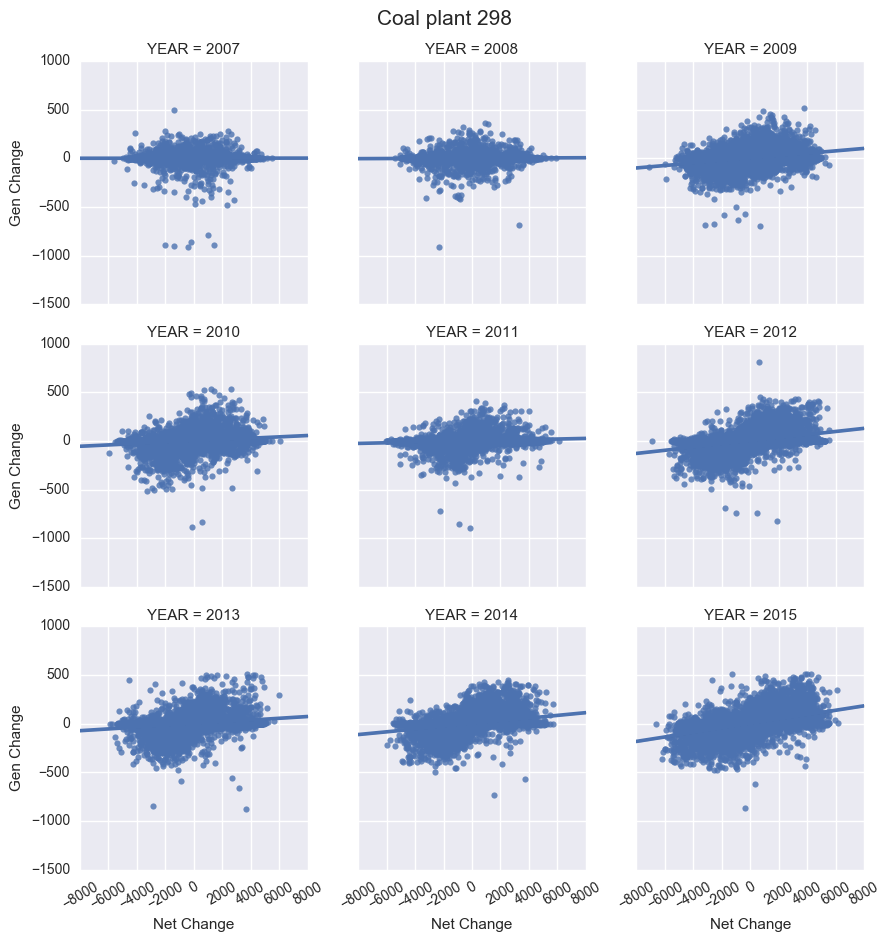

In [40]:
g = sns.FacetGrid(test[test['PLANT_ID']==298], col='YEAR', col_wrap=3)
g.map(sns.regplot, 'Net Change', 'Gen Change')
g.set_xticklabels(rotation=30)
plt.suptitle('Coal plant 298', y=1.02, size=15)

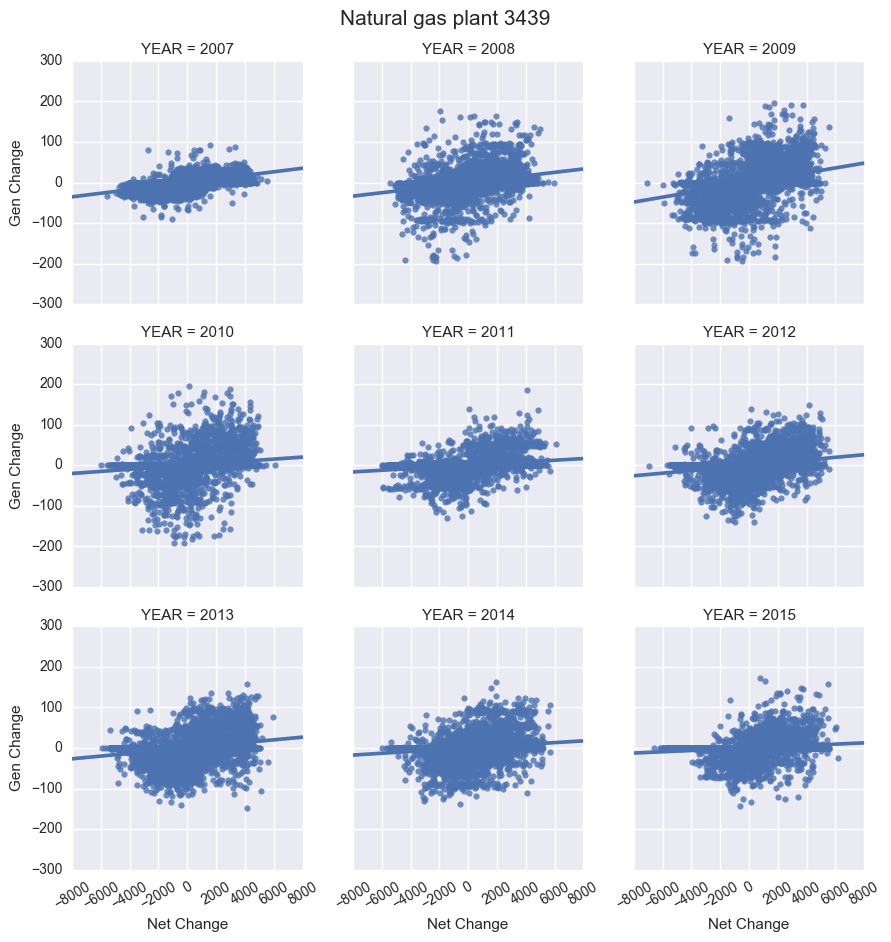

In [35]:
g = sns.FacetGrid(test[test['PLANT_ID']==3439], col='YEAR', col_wrap=3)
g.map(sns.regplot, 'Net Change', 'Gen Change')
g.set_xticklabels(rotation=30)
plt.suptitle('Natural gas plant 3439', y=1.02, size=15)